In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec

from green_mood_tracker.training_data import get_raw_data_notebook
from green_mood_tracker.data_cleaning import clean

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cleme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## download and clean data

In [2]:
%%time
raw_data = get_raw_data_notebook(True)
raw_data.head()

c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sentiment140_final['source'] = 'sentiment140'
c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\training_data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  complete_data_binary['polarity'] = complete_data_binary.polarity.map({4:1,0:0})


Wall time: 8.3 s


,id,text,polarity,source
0,1467933112,the angel is going to miss the athlete this we...,0,sts_gold
1,2323395086,It looks as though Shaq is getting traded to C...,0,sts_gold
2,1467968979,@clarianne APRIL 9TH ISN'T COMING SOON ENOUGH,0,sts_gold
3,1990283756,drinking a McDonalds coffee and not understand...,0,sts_gold
4,1988884918,So dissapointed Taylor Swift doesnt have a Twi...,0,sts_gold


In [3]:
raw_data.shape

(1620501, 4)

## Explore data

In [4]:
raw_data.source.value_counts()

sentiment140              1600000
kaggle_sentiment_train      16363
kaggle_sentiment_test        2104
sts_gold                     2034
Name: source, dtype: int64

In [5]:
raw_data.polarity.value_counts()

1    810317
0    810184
Name: polarity, dtype: int64

## sample data

In [6]:
# data_sample = raw_data[raw_data.source == 'sts_gold']
data_sample = raw_data[raw_data.source != 'sentiment140']

In [7]:
%%time
data_sample_clean = clean(data_sample,'text')
data_sample_clean.head()

c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[column] = df[column].apply(lambda x1: " ".join(
c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\data_cleaning.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[column] = df[column].apply(lambda x: x.translate(
c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\data_cleaning.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Wall time: 5.4 s


c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\data_cleaning.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[column] = df[column].apply(lambda x: ' '.join(


,id,text,polarity,source
0,1467933112,angel going miss athlete weekend,0,sts_gold
1,2323395086,look though shaq getting traded cleveland play...,0,sts_gold
2,1467968979,april th isnt coming soon enough,0,sts_gold
3,1990283756,drinking mcdonalds coffee understanding someon...,0,sts_gold
4,1988884918,dissapointed taylor swift doesnt twitter,0,sts_gold


## split data Train/Test

In [8]:
from sklearn.model_selection import train_test_split

X = data_sample_clean.text.map(lambda x: x.split())
y = data_sample_clean.polarity

In [9]:
sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

## word2vec

In [11]:
# word2vec = Word2Vec(sentences=sentence_train)
# vocab_size=len(word2vec.wv.vocab.keys())

In [12]:
# vocab_size

In [13]:
def embed_sentence(word2vec, sentence):
    embedded=[]
    embedded_sentence = []
    for word in sentence:
         if word in word2vec.wv.vocab.keys():
             vector = word2vec.wv[word]
             embedded_sentence.append(vector)                 
    return np.array(embedded_sentence)
        

In [14]:
def embedding(word2vec, sentences):
    embedding=[]
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)  
        embedding.append(embedded_sentence)
    return embedding

In [15]:
def embedding_pipeline(word2vec, X):
    # Step #3: Sentences to list of words
    X = embedding(word2vec, X) 
    # Step #4: Pad the inputs
    X = pad_sequences(X, dtype='float32', padding='post') 
    return X

In [16]:
# X_train_pad_w2v = embedding_pipeline(word2vec, sentence_train.values)
# X_test_pad_w2v = embedding_pipeline(word2vec, sentence_test.values)

In [17]:
def init_model_w2v():

    model = Sequential()

    model.add(layers.Masking(mask_value=0.))
    model.add(layers.GRU(units=32, activation='tanh', return_sequences=True)) 
    model.add(layers.GRU(units=16, activation='tanh')) 
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss= 'binary_crossentropy',  
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

### Train word2vec on internal data

In [18]:
# %%time
# model_w2v = init_model_w2v()

# es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
# history_w2v = model_w2v.fit(X_train_pad_w2v, y_train,
#           validation_split= 2/7,
#           epochs=50, 
#           batch_size=32, 
#           verbose=1,
#           use_multiprocessing=True,
#           callbacks = [es])

In [19]:
# print('accuracy', model_w2v.evaluate(X_test_pad_w2v,y_test)[1])
# plot_loss(history_w2v)

### Train word2vec on Google news

In [20]:
%%time
import gensim.downloader as api

Wall time: 3.99 ms


In [21]:
%%time
word2vec_gnews = api.load("word2vec-google-news-300")

Wall time: 1min 13s


In [22]:
X_train_pad_w2v_gnews = embedding_pipeline(word2vec_gnews, sentence_train.values)
X_test_pad_w2v_gnews = embedding_pipeline(word2vec_gnews, sentence_test.values)

c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [23]:
X_test_pad_w2v_gnews.shape

(4101, 19, 300)

In [24]:
len(word2vec_gnews.wv.vocab)

c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


3000000

In [25]:
%%time
model_w2v_gnews = init_model_w2v()

es = EarlyStopping(patience=10,restore_best_weights=True,monitor='val_accuracy')
history_w2v_gnews = model_w2v_gnews.fit(X_train_pad_w2v_gnews, y_train,
          validation_split= 2/7,
          epochs=50, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/50
367/367 [==============================] - 12s 32ms/step - loss: 0.4352 - accuracy: 0.8149 - val_loss: 0.3534 - val_accuracy: 0.8555
Epoch 2/50
367/367 [==============================] - 9s 26ms/step - loss: 0.3431 - accuracy: 0.8627 - val_loss: 0.3167 - val_accuracy: 0.8717
Epoch 3/50
367/367 [==============================] - 9s 25ms/step - loss: 0.3122 - accuracy: 0.8738 - val_loss: 0.3087 - val_accuracy: 0.8735
Epoch 4/50
367/367 [==============================] - 10s 26ms/step - loss: 0.2939 - accuracy: 0.8836 - val_loss: 0.3431 - val_accuracy: 0.8551
Epoch 5/50
367/367 [==============================] - 11s 29ms/step - loss: 0.2805 - accuracy: 0.8887 - val_loss: 0.3584 - val_accuracy: 0.8515
Epoch 6/50
367/367 [==============================] - 10s 27ms/step - loss: 0.2681 - accuracy: 0.8947 - val_loss: 0.3180 - val_accuracy: 0.8696
Epoch 7/50
367/367 [==============================] - 10s 27ms/step - loss: 0.2546 - accuracy: 0.9000 - val_loss: 0.3475 - val_accuracy: 0

129/129 [==============================] - 1s 7ms/step - loss: 0.3371 - accuracy: 0.8671
accuracy 0.8671056032180786


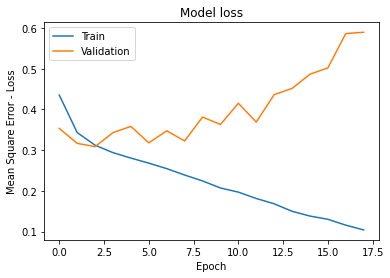

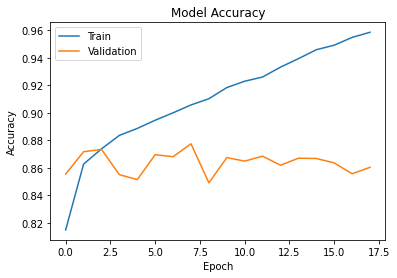

In [26]:
print('accuracy', model_w2v_gnews.evaluate(X_test_pad_w2v_gnews,y_test)[1])
plot_loss(history_w2v_gnews)

In [27]:
%%time
word2vec_glove = api.load("glove-twitter-100")

Wall time: 2min 54s


In [28]:
len(word2vec_glove.wv.vocab)

c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


1193514

In [29]:
X_train_pad_w2v_glove = embedding_pipeline(word2vec_glove, sentence_train.values)
X_test_pad_w2v_glove = embedding_pipeline(word2vec_glove, sentence_test.values)

c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [30]:
%%time
model_w2v_glove = init_model_w2v()

es = EarlyStopping(patience=10,restore_best_weights=True,monitor='val_accuracy')
history_w2v_glove = model_w2v_glove.fit(X_train_pad_w2v_glove, y_train,
          validation_split= 2/7,
          epochs=50, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/50
367/367 [==============================] - 8s 23ms/step - loss: 0.4405 - accuracy: 0.8043 - val_loss: 0.3451 - val_accuracy: 0.8528
Epoch 2/50
367/367 [==============================] - 8s 21ms/step - loss: 0.3408 - accuracy: 0.8614 - val_loss: 0.3436 - val_accuracy: 0.8523
Epoch 3/50
367/367 [==============================] - 7s 19ms/step - loss: 0.3128 - accuracy: 0.8733 - val_loss: 0.3265 - val_accuracy: 0.8671
Epoch 4/50
367/367 [==============================] - 7s 19ms/step - loss: 0.2934 - accuracy: 0.8797 - val_loss: 0.3042 - val_accuracy: 0.8722
Epoch 5/50
367/367 [==============================] - 7s 20ms/step - loss: 0.2796 - accuracy: 0.8859 - val_loss: 0.3013 - val_accuracy: 0.8754
Epoch 6/50
367/367 [==============================] - 11s 29ms/step - loss: 0.2682 - accuracy: 0.8907 - val_loss: 0.3053 - val_accuracy: 0.8764
Epoch 7/50
367/367 [==============================] - 10s 28ms/step - loss: 0.2550 - accuracy: 0.8933 - val_loss: 0.3167 - val_accuracy: 0.87

129/129 [==============================] - 1s 5ms/step - loss: 0.3175 - accuracy: 0.8769
accuracy 0.8768593072891235


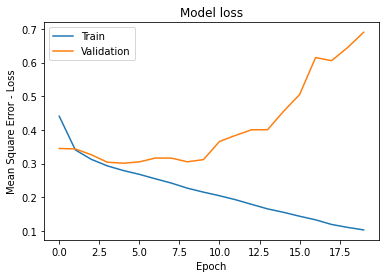

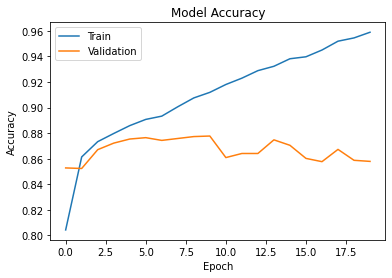

In [31]:
print('accuracy', model_w2v_glove.evaluate(X_test_pad_w2v_glove,y_test)[1])
plot_loss(history_w2v_glove)

In [36]:
import joblib

filename = '../green_mood_tracker/models/model_w2v_binary.joblib'
joblib.dump(model_w2v_glove, filename)

# import pickle

# filename = 'model_emb_binary.sav'
# pickle.dump(model_emb, open(filename, 'wb'))

TypeError: can't pickle _thread.RLock objects

In [37]:
model = joblib.load(filename)

EOFError: 

## Evaluate

In [33]:
# print('w2v_internal accuracy:',model_w2v.evaluate(X_test_pad_w2v,y_test))

In [34]:
# print('w2v_gnews accuracy:',model_w2v_gnews.evaluate(X_test_pad_w2v_gnews,y_test))

### Predict on London

In [35]:
# csv = pd.read_csv('../green_mood_tracker/data/london_nuclear.csv')